In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/sample_data/train.csv', na_values='?')

# Exploratory Data Analysis

Data Types

In [3]:
df.shape

(1022, 82)

In [4]:
categorical = df.select_dtypes(include=['object']).columns
print(f'{categorical}\n Total object columns: {len(categorical)}')
non_categorical = df.select_dtypes(exclude=['object']).columns
print(f'{non_categorical}\n Total numerical columns: {len(non_categorical)}')

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
 Total object columns: 43
Index(['Unnamed: 0', 'Id', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       

In [5]:
def unique_val_count(data,categorical):
    cat_data = []
    for col in categorical:
      col_data = {
        'col_name': col,
        'unique_val': df[col].unique(),
        'uni_val_count': len(df[col].unique()),
        'nuni_val_count': df[col].nunique(),
        'total_miss_val': df[col].isnull().sum(),
        'per_of_miss': round((df[col].isnull().sum() / len(df)) * 100, 2)
      }
      cat_data.append(col_data)
    cat_df = pd.DataFrame(cat_data)
    return  cat_df
cat_df = unique_val_count(df, categorical)
print(cat_df.shape)
print(cat_df[(cat_df['per_of_miss']>0)][['col_name','uni_val_count','nuni_val_count','total_miss_val', 'per_of_miss']]
      .sort_values(by='per_of_miss', ascending=False).reset_index(drop=True))

(43, 6)
        col_name  uni_val_count  nuni_val_count  total_miss_val  per_of_miss
0         PoolQC              4               3            1017        99.51
1    MiscFeature              4               3             990        96.87
2          Alley              3               2             962        94.13
3          Fence              5               4             824        80.63
4    FireplaceQu              6               5             480        46.97
5     GarageType              7               6              54         5.28
6   GarageFinish              4               3              54         5.28
7     GarageQual              6               5              54         5.28
8     GarageCond              6               5              54         5.28
9   BsmtExposure              5               4              30         2.94
10  BsmtFinType2              7               6              30         2.94
11      BsmtQual              5               4              29     

#### Categorical Feature Analysis

In [6]:
from scipy.stats import chi2_contingency, pearsonr
# data1 = df.copy()
# data1.drop(['Unnamed: 0', 'Id',],axis=1, inplace=True)
def chi_square(data, features, column_names):
  significant = pd.DataFrame(columns=column_names)
  less_significant = pd.DataFrame(columns=column_names)
  for val in features:
    contingency = pd.crosstab(data['SalePrice'], data[val])
    c, p, dof, exp = chi2_contingency(contingency)
    d1 = {column_names[0]: [val], column_names[1]: [p]}
    if p < 0.05:
        significant = pd.concat([significant, pd.DataFrame(d1)], ignore_index=True)
    else:
        less_significant = pd.concat([less_significant, pd.DataFrame(d1)], ignore_index=True)
  return significant, less_significant

significant_before, less_significant_before = chi_square(df, categorical, ['before_replace_missval','p-val'])

def mode_imputation(data, features):
  for col in features:
    if data[col].isna().any():
      mode_val = data[col].mode()[0] if not pd.isnull(data[col].mode()[0]) else data[col].mode()[1]
      data[col].fillna(mode_val, inplace=True)
    else:
      continue
  return data
data1 = mode_imputation(df, categorical)
df = mode_imputation(df, categorical)

significant_after, less_significant_after = chi_square(data1, categorical,  ['after_replace_missval','p-value'])
significant_ = pd.concat([significant_before, significant_after], axis=1)
chi_sq_test = significant_['after_replace_missval'].to_list()
less_significant_ = pd.concat([less_significant_before, less_significant_after], axis=1)

In [7]:
significant_

,before_replace_missval,p-val,after_replace_missval,p-value
0,MSZoning,3.618565e-07,MSZoning,3.618565e-07
1,Street,2.674388e-06,Street,2.674388e-06
2,LotShape,4.895314e-11,LotShape,4.895314e-11
3,LandContour,8.013529e-03,LandContour,8.013529e-03
4,LotConfig,3.904399e-05,LotConfig,3.904399e-05
5,LandSlope,2.178401e-02,LandSlope,2.178401e-02
6,Neighborhood,1.461431e-07,Neighborhood,1.461431e-07
7,Condition2,2.816805e-02,Condition2,2.816805e-02
8,MasVnrType,2.672784e-02,MasVnrType,3.144278e-02
9,ExterQual,1.396684e-20,ExterQual,1.396684e-20


There is no difference in p-value before and after mode imputation. Hence, we can consider rest of the column as less significant features!!

       col_name  uni_val_count
0  Neighborhood             24
1    Condition1              9
2    Condition2              8
3    HouseStyle              8
4      RoofMatl              7
5   Exterior1st             13
6   Exterior2nd             15
7      SaleType              9


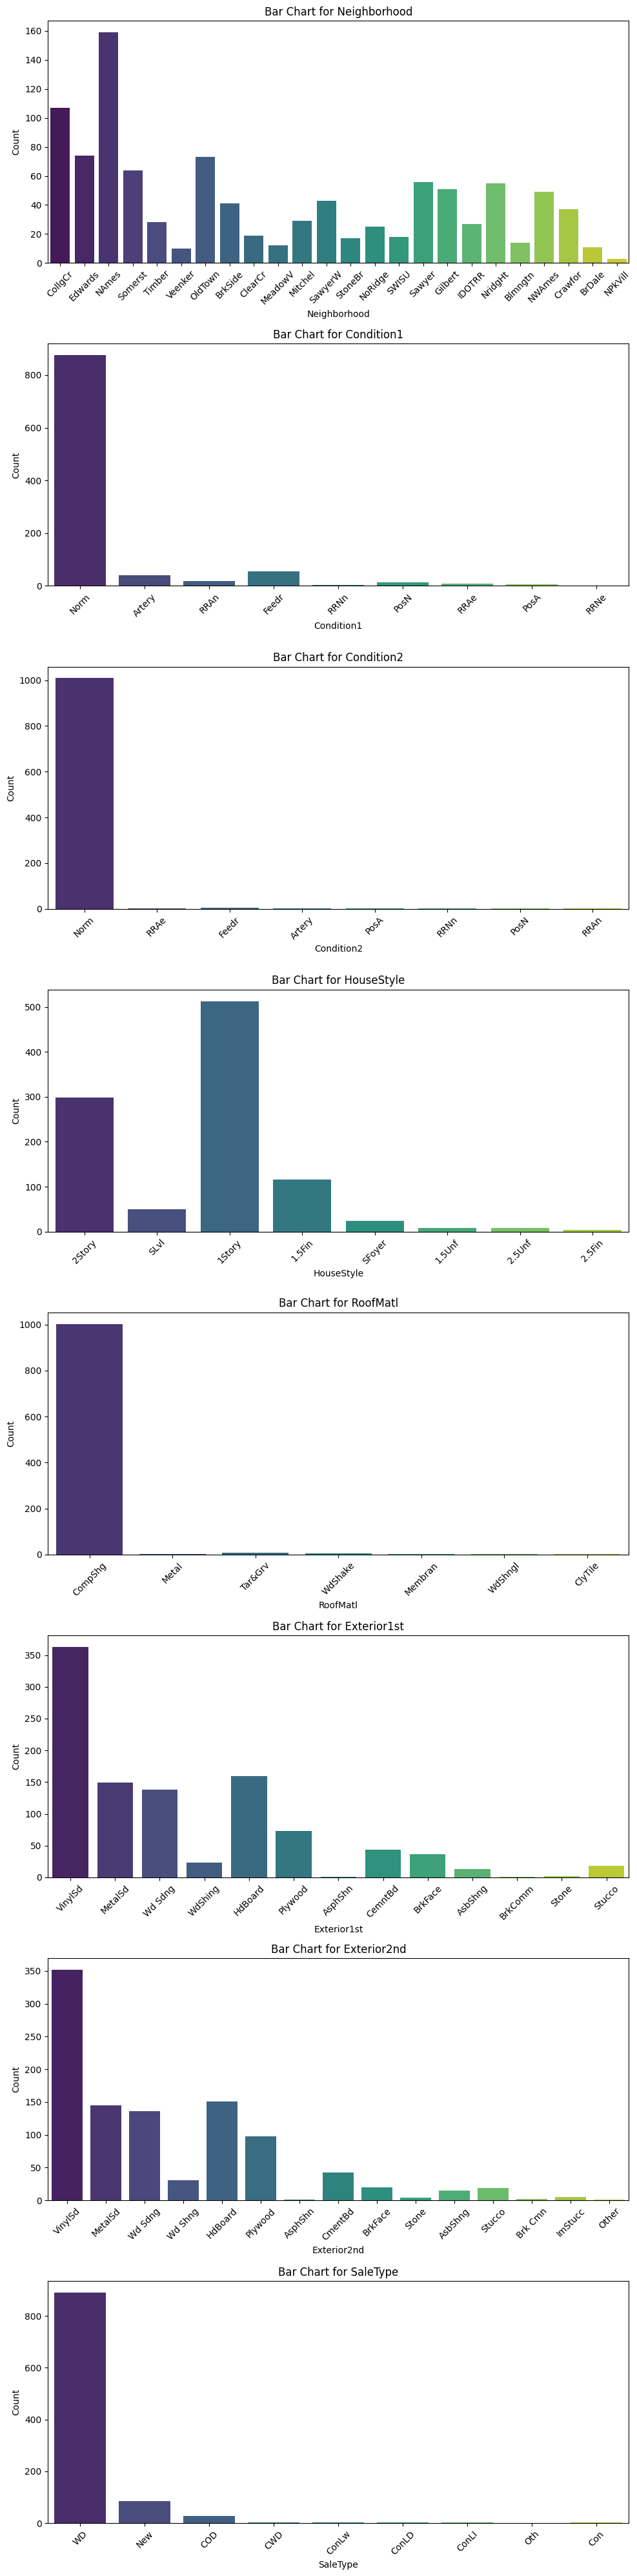

In [8]:
uni_df = unique_val_count(df, categorical)
print(uni_df[uni_df['uni_val_count'] > 6][['col_name','uni_val_count']].reset_index(drop=True))
lst1 = uni_df[uni_df['uni_val_count'] > 6]['col_name'].tolist()
fig, axs = plt.subplots(nrows=len(lst1), figsize=(10, 5 * len(lst1)))
for i, column in enumerate(lst1):
    sns.countplot(x=column, data=df, ax=axs[i], palette='viridis')
    axs[i].set_title(f'Bar Chart for {column}')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Above Given, Features has many unique values which are unevenly spreaded. Hence, It can affect while converting non-categorical features. With one hot encoding it can increase number of feature column which can create baises in the data. However, There are some columns which has high significance and correlation with the target variable, features like Neighborhood , SaleType. Hence, We will not remove these features.

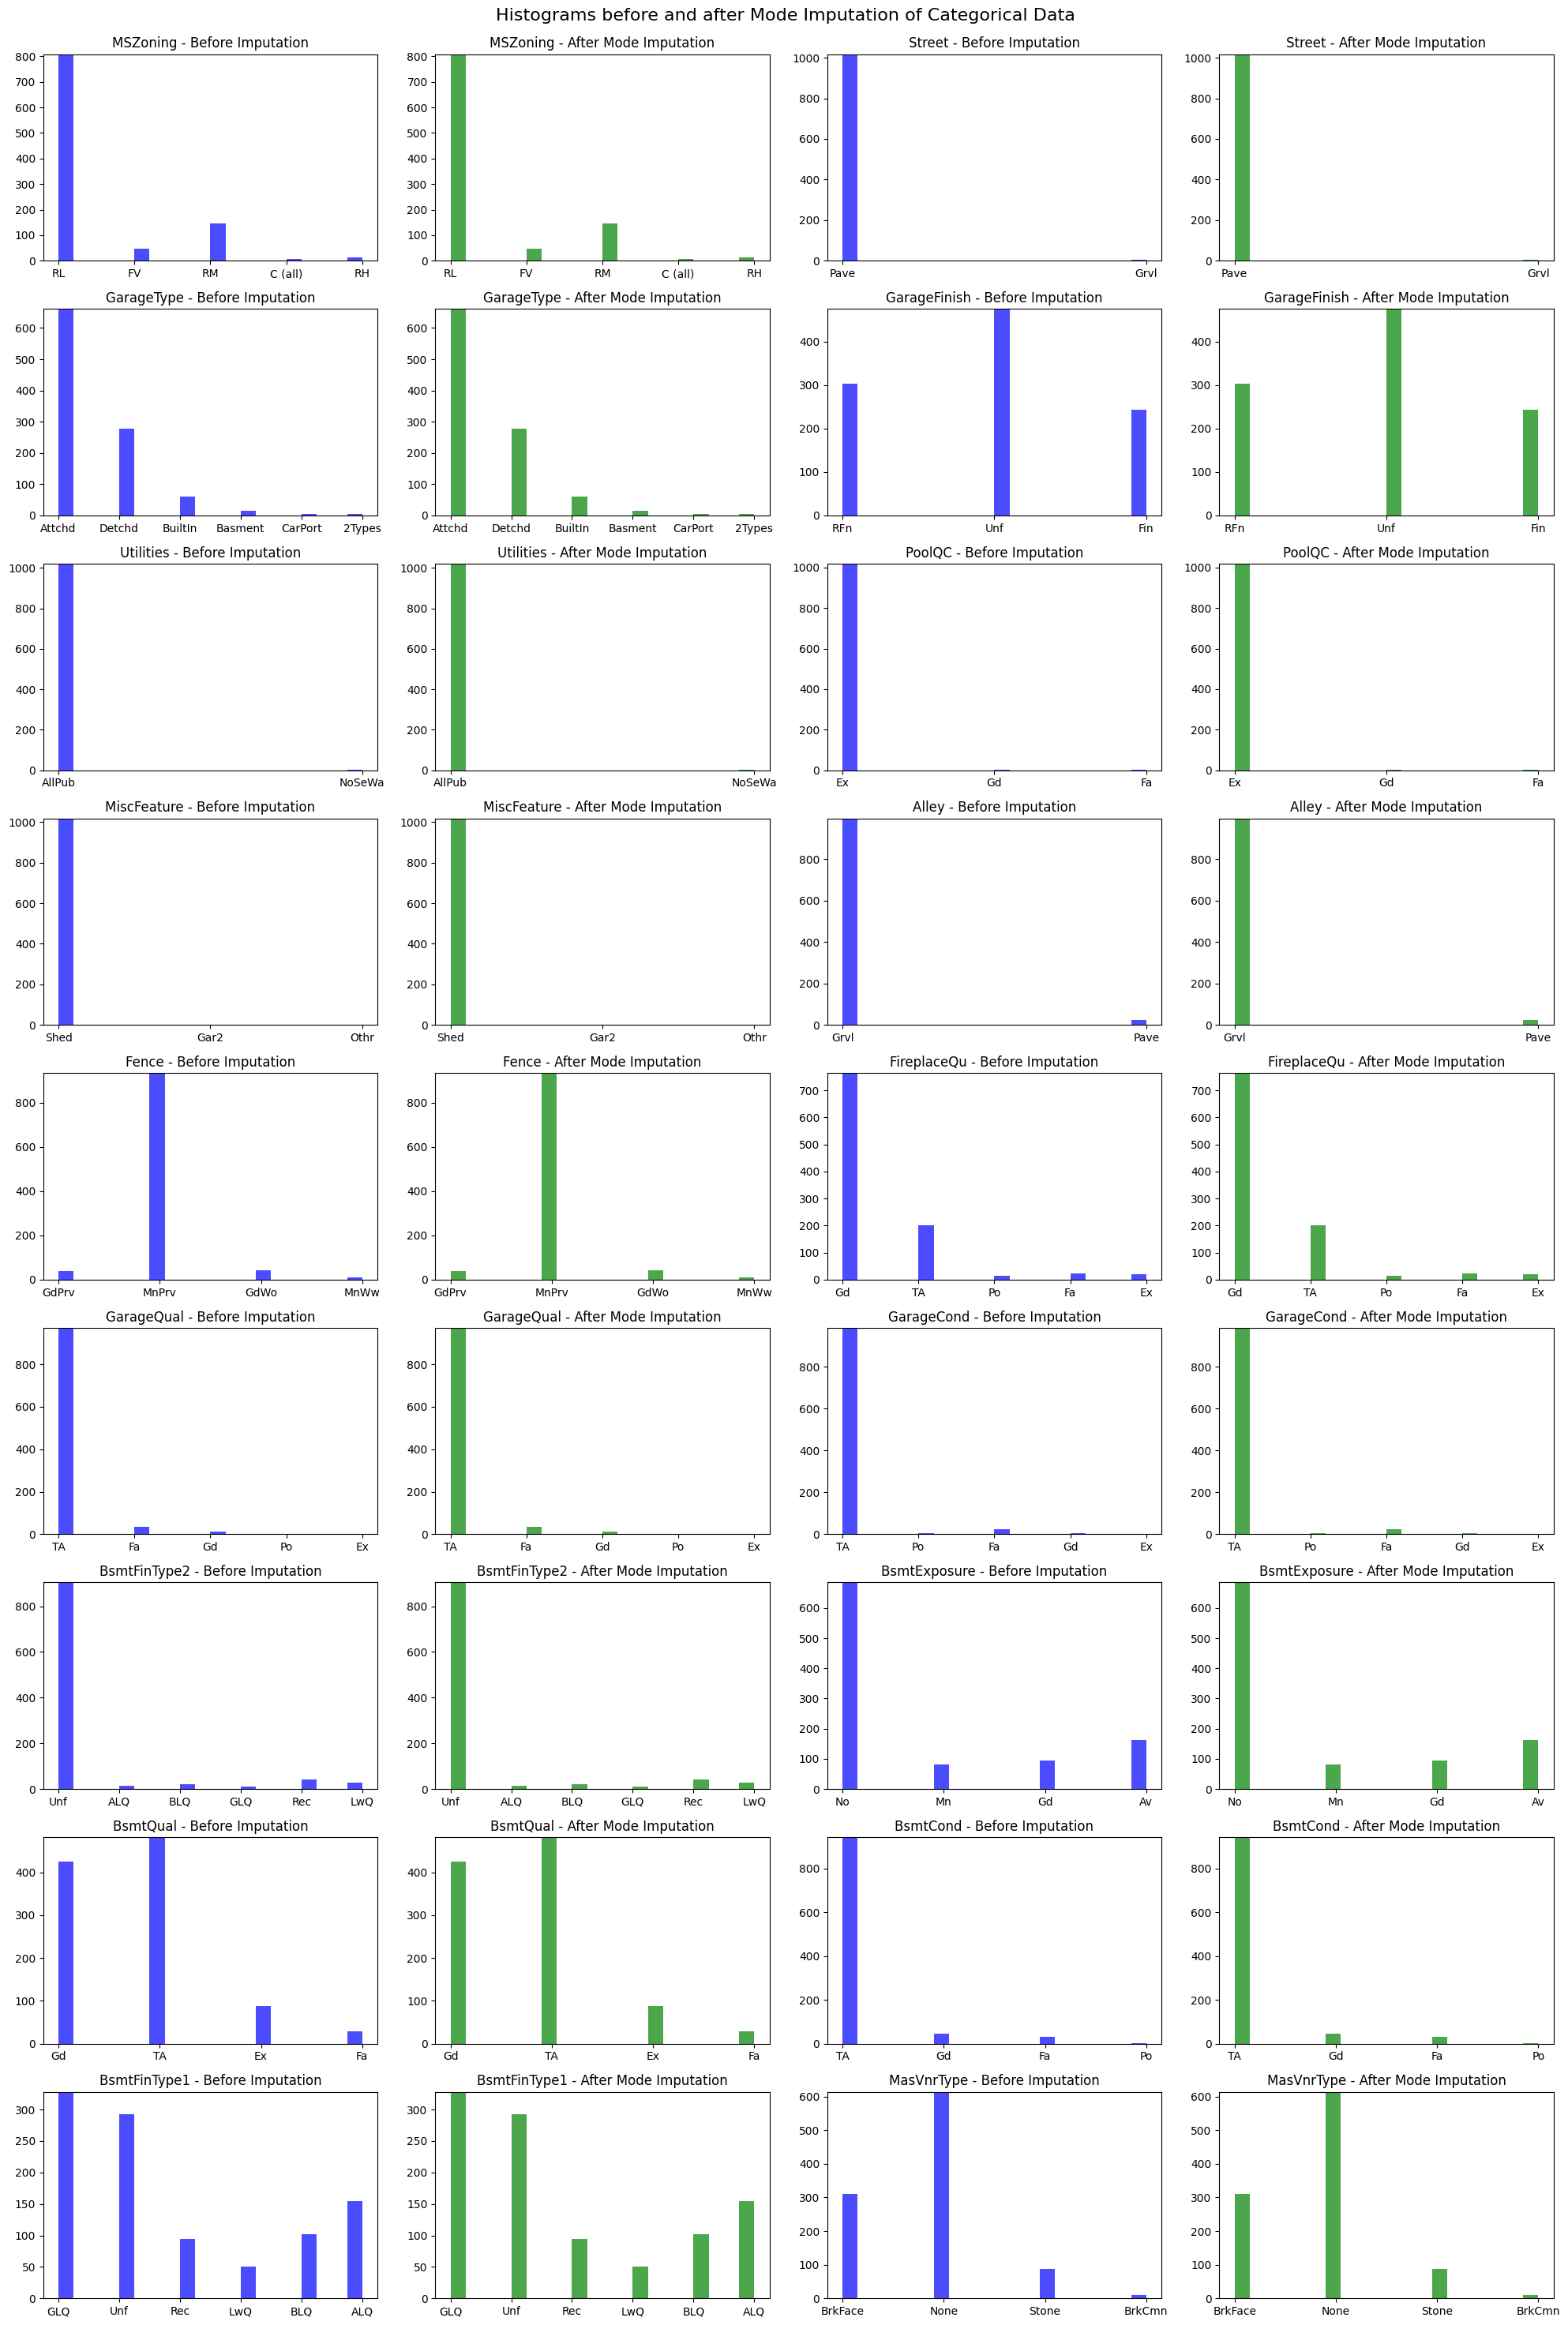

In [9]:
features = ['MSZoning', 'Street', 'GarageType', 'GarageFinish','Utilities',
            'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
            'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType']

plt.figure(figsize=(20, 30))
plt.suptitle('Histograms before and after Mode Imputation of Categorical Data\n\n', fontsize=16)

max_y1_list = [max(df[col].dropna().value_counts()) for col in features]
max_y2_list = [max(data1[col].dropna().value_counts()) for col in features]

for i, col in enumerate(features):
    plt.subplot(9, 4, i * 2 + 1)
    plt.hist(df[col].dropna(), bins=20, color='blue', alpha=0.7)
    plt.title(f'{col} - Before Imputation')
    plt.ylim(0, max(max_y1_list[i], max_y2_list[i]))

    plt.subplot(9, 4, i * 2 + 2)
    plt.hist(data1[col].dropna(), bins=20, color='green', alpha=0.7)
    plt.title(f'{col} - After Mode Imputation')
    plt.ylim(0, max(max_y1_list[i], max_y2_list[i]))

plt.tight_layout()
plt.show()


#### Non-Categorical Feature Analysis

In [10]:
sparse = []
sparsed = {}
for feature in non_categorical:
    counts = df[feature].value_counts()
    zeros = counts.iloc[0]
    per = zeros / len(df) * 100
    if per > 90.94:
        sparse.append(feature)
    sparsed[feature] = per
sparsed = pd.DataFrame(sparsed.items(), columns=['Features','Sparsity_Percentage'])
# df.drop(columns=sparse, inplace=True)
# print(f'Dropped {len(sparse)} columns that are {sparse}')

In [11]:
sparsed.sort_values(by=['Sparsity_Percentage'], ascending=False).reset_index(drop=True)

,Features,Sparsity_Percentage
0,PoolArea,99.510763
1,3SsnPorch,98.238748
2,LowQualFinSF,98.140900
3,MiscVal,97.064579
4,KitchenAbvGr,95.694716
5,BsmtHalfBath,94.422701
6,ScreenPorch,91.976517
7,BsmtFinSF2,88.356164
8,EnclosedPorch,86.203523
9,HalfBath,63.209393


In [12]:
def calculate_correlation(data, categorical_cols):
    df_ = data.drop(categorical_cols, axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    df_.rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: 'Correlation_Coefficient'}, inplace=True)
    df__ = df_.drop(df_[df_['Correlation_Coefficient'] == 1.0].index)
    return df__
categorical = df.select_dtypes(include=['object']).columns
corr_df = calculate_correlation(df, categorical)
corr_df = corr_df[corr_df['Feature_1'] == 'SalePrice']
corr_df = corr_df[corr_df['Correlation_Coefficient'] >= 0.2]

In [13]:
corr_df.reset_index(drop=True)

,Feature_1,Feature_2,Correlation_Coefficient
0,SalePrice,OverallQual,0.789634
1,SalePrice,GrLivArea,0.719985
2,SalePrice,GarageCars,0.634395
3,SalePrice,GarageArea,0.626319
4,SalePrice,TotalBsmtSF,0.612676
5,SalePrice,1stFlrSF,0.611725
6,SalePrice,FullBath,0.570163
7,SalePrice,TotRmsAbvGrd,0.555989
8,SalePrice,YearBuilt,0.542773
9,SalePrice,YearRemodAdd,0.510283


In [14]:
corr_col = corr_df['Feature_2'].tolist()

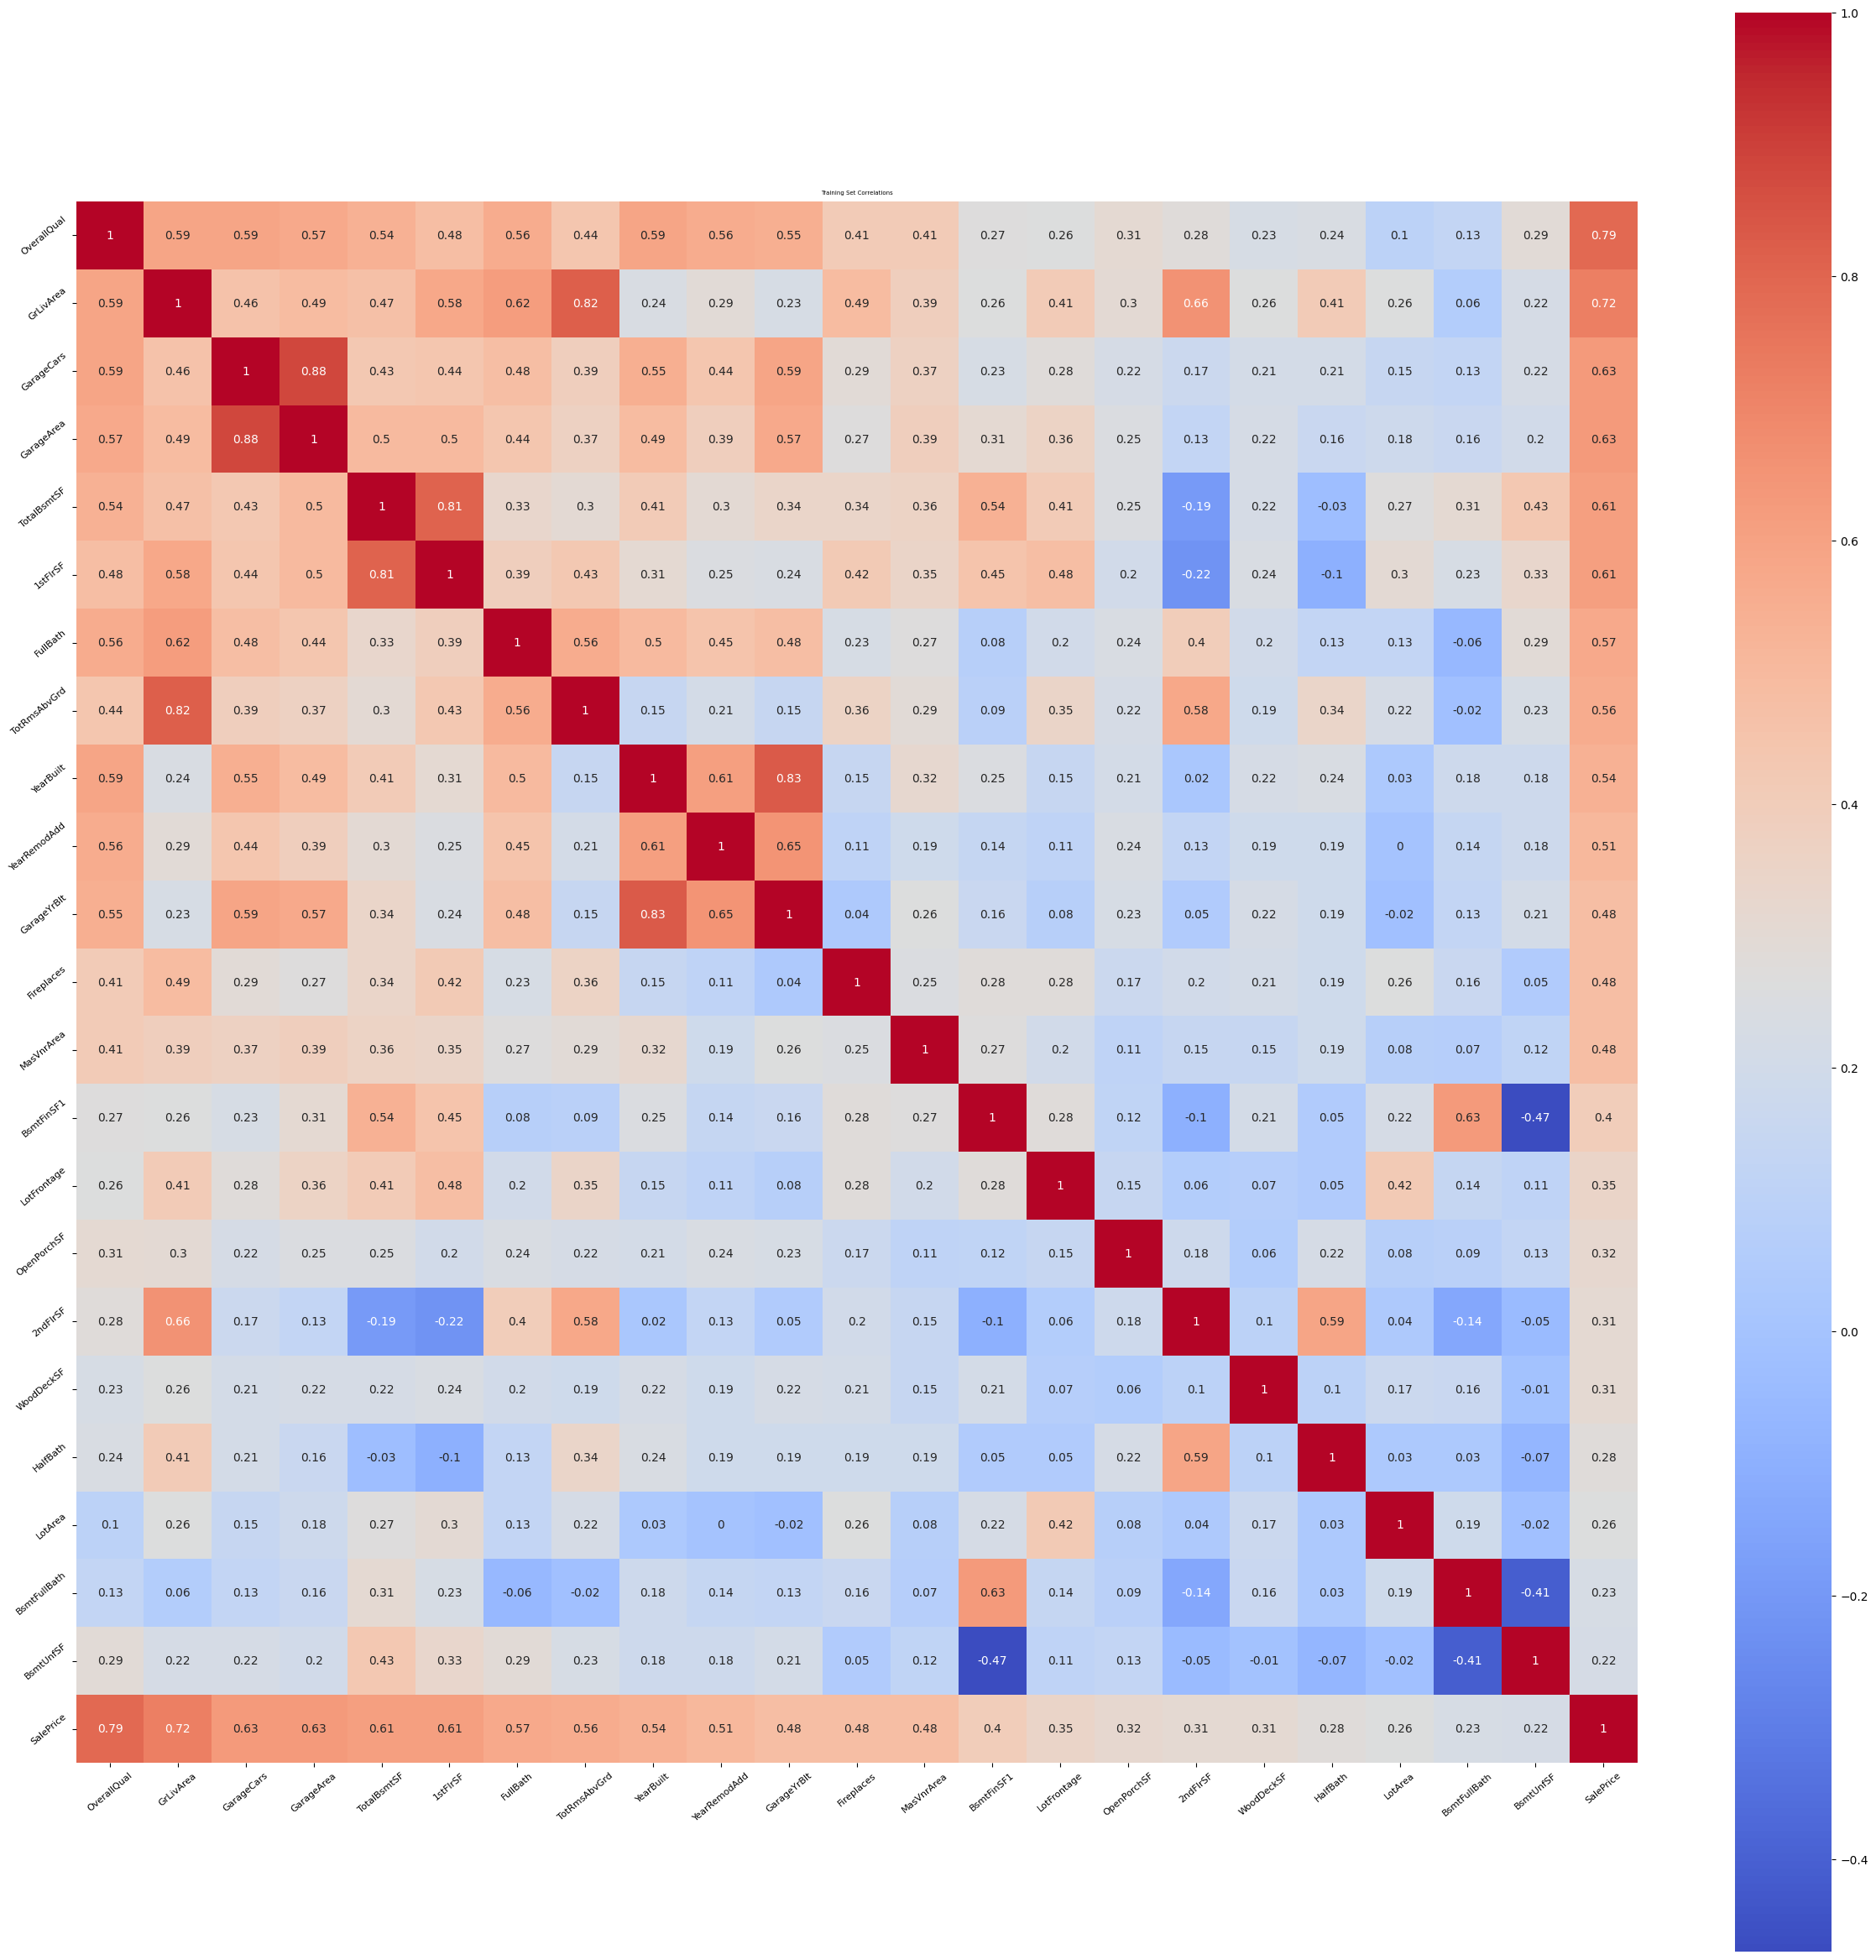

In [15]:
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(30, 30))
sns.heatmap((df[corr_col + ['SalePrice']]).corr().round(2), ax=axs, annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})
axs.tick_params(axis='x', labelsize=8, rotation=40)
axs.tick_params(axis='y', labelsize=8, rotation=40)
axs.set_title('Training Set Correlations', size=5)
plt.show()

From Above Non Categorical Features, It can be said that
'GarageArea'-'GarageCars', '1stFlrSF'-'TotalBsmtSF','TotRmsAbvGrd'-'GrLivArea', 'GarageYrBlt'-'YearBuilt' are highly related features. Hence, Dropping those which are less correleated to the Saleprice for above absorved pairs. Those are ['GarageArea', '1stFlrSF', 'GarageYrBlt','TotRmsAbvGrd']

In [16]:
df.drop(['GarageYrBlt'], axis=1, inplace=True) # Only Dropping Garage Year Built as it has high correlation with YearRemodAdd amd Yearbuilt

In [17]:
non_categorical = df.select_dtypes(exclude=['object']).columns
print(f'{non_categorical}\n Total numerical columns: {len(non_categorical)}')

Index(['Unnamed: 0', 'Id', 'MSSubClass', 'LotFrontage', 'LotArea',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
 Total numerical columns: 38


In [18]:
non_cat_df = []

for col in non_categorical:
    col_data = {
        'col_name': col,
        'total_miss_val': df[col].isnull().sum(),
        'per_of_miss': round((df[col].isnull().sum() / len(df)) * 100, 2)
    }
    non_cat_df.append(col_data)

non_cat_df = pd.DataFrame(non_cat_df)
non_cat_df[(non_cat_df['per_of_miss']>0)]

,col_name,total_miss_val,per_of_miss
3,LotFrontage,180,17.61
9,MasVnrArea,7,0.68


Numerical Feature Missing Value Imputation

In [19]:
selected_columns = ['LotFrontage', 'MasVnrArea']
summary_stats = df[selected_columns].agg(['count', 'mean', 'median', 'min', 'max']).transpose()
summary_stats['mode'] = df[selected_columns].mode().transpose().iloc[:, 0]
summary_stats.columns = ['count', 'mean','median', 'min', 'max', 'mode']
print(summary_stats)

              count        mean  median   min     max  mode
LotFrontage   842.0   70.261283    70.0  21.0   313.0  60.0
MasVnrArea   1015.0  102.175369     0.0   0.0  1600.0   0.0


Simple Imputation

In [20]:
selected_columns = ['LotFrontage', 'MasVnrArea']
df_selected = df[selected_columns].copy()
df_selected_mean_imputed = df_selected.fillna(df_selected.mean())
df_selected_median_imputed = df_selected.fillna(df_selected.median())

KNN Imputation

In [21]:
knn_imputer = KNNImputer(n_neighbors=5)
df_selected_imputed = pd.DataFrame(knn_imputer.fit_transform(df_selected), columns=selected_columns)

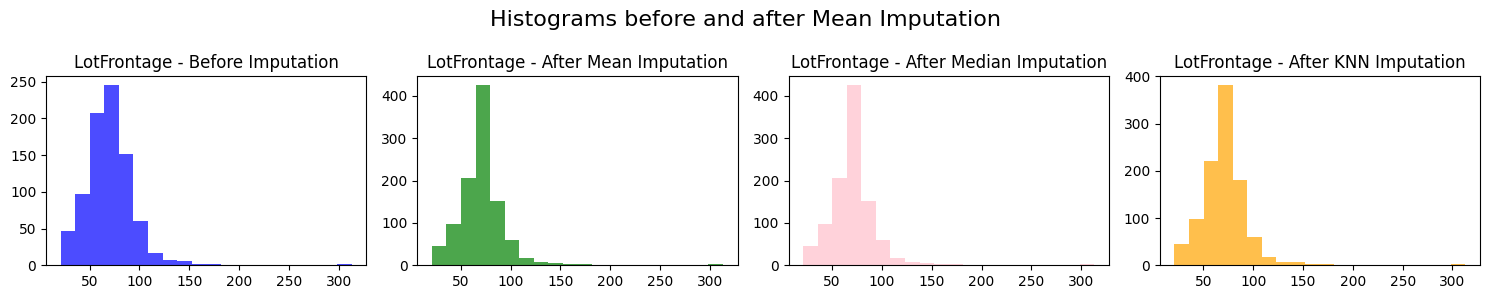

In [22]:
plt.figure(figsize=(15, 3))
plt.suptitle('Histograms before and after Mean Imputation', fontsize=16)

plt.subplot(1, 4, 1)
plt.hist(df_selected['LotFrontage'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('LotFrontage - Before Imputation')

plt.subplot(1, 4, 2)
plt.hist(df_selected_mean_imputed['LotFrontage'], bins=20, color='green', alpha=0.7)
plt.title('LotFrontage - After Mean Imputation')

plt.subplot(1, 4, 3)
plt.hist(df_selected_median_imputed['LotFrontage'], bins=20, color='pink', alpha=0.7)
plt.title('LotFrontage - After Median Imputation')

plt.subplot(1, 4, 4)
plt.hist(df_selected_imputed['LotFrontage'], bins=20, color='orange', alpha=0.7)
plt.title('LotFrontage - After KNN Imputation')

plt.tight_layout()
plt.show()

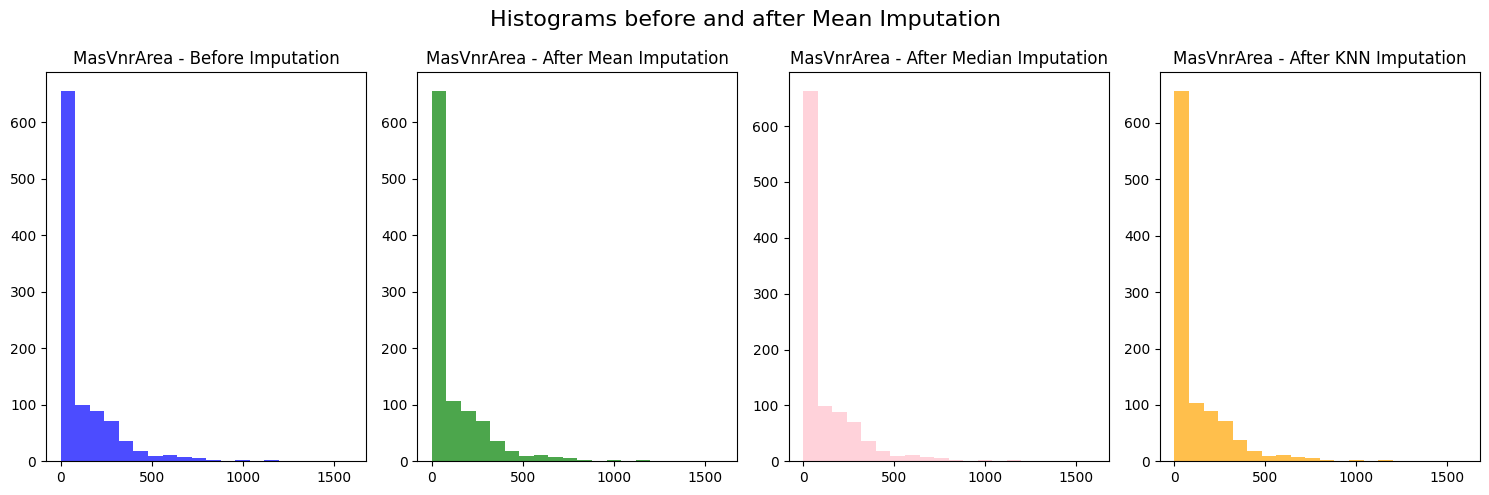

In [23]:
plt.figure(figsize=(15, 5))
plt.suptitle('Histograms before and after Mean Imputation', fontsize=16)

plt.subplot(1, 4, 1)
plt.hist(df_selected['MasVnrArea'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('MasVnrArea - Before Imputation')

plt.subplot(1, 4, 2)
plt.hist(df_selected_mean_imputed['MasVnrArea'], bins=20, color='green', alpha=0.7)
plt.title('MasVnrArea - After Mean Imputation')

plt.subplot(1, 4, 3)
plt.hist(df_selected_median_imputed['MasVnrArea'], bins=20, color='pink', alpha=0.7)
plt.title('MasVnrArea - After Median Imputation')

plt.subplot(1, 4, 4)
plt.hist(df_selected_imputed['MasVnrArea'], bins=20, color='orange', alpha=0.7)
plt.title('MasVnrArea - After KNN Imputation')

plt.tight_layout()
plt.show()

Both Simple Mean Imputation and KNN Imputation are viable methods for handling missing values without significantly altering the data's underlying statistics or distribution. Given the simplicity of Simple Mean Imputation and the relatively small size of the dataset, it is considered the most suitable approach for this particular scenario. This eliminates the need for more intricate imputation techniques

# Task 1: Feature Selection

#### Pearson Test to check the signifcance of the data

In [24]:
import pandas as pd
from scipy.stats import pearsonr

non_cat = non_categorical.drop(['SalePrice', 'Unnamed: 0', 'Id'])
df['LotFrontage'] = df_selected_imputed['LotFrontage']
df['MasVnrArea'] = df_selected_imputed['MasVnrArea']
# data1['GarageYrBlt'] = df_selected_median_imputed['GarageYrBlt']

def pearson_correlation(data, features, target_column):
    significant = pd.DataFrame(columns=['column', 'correlation'])
    less_significant = pd.DataFrame(columns=['column', 'correlation'])

    for val in features:
        c, p = pearsonr(data[val], data[target_column])
        d1 = {'column': [val], 'correlation': [c]}

        if  abs(c) > 0.25:
            significant = pd.concat([significant, pd.DataFrame(d1)], ignore_index=True)
        else:
            less_significant = pd.concat([less_significant, pd.DataFrame(d1)], ignore_index=True)

    return significant, less_significant

significant_p, less_significant_p = pearson_correlation(df, non_categorical, 'SalePrice')

print("Significant correlations:")
print(significant_p.sort_values('correlation', ascending=False))
pearson_test = significant_p['column'].to_list()

Significant correlations:
          column  correlation
19     SalePrice     1.000000
2    OverallQual     0.789634
10     GrLivArea     0.719985
15    GarageCars     0.634395
16    GarageArea     0.626319
7    TotalBsmtSF     0.612676
8       1stFlrSF     0.611725
11      FullBath     0.570163
13  TotRmsAbvGrd     0.555989
3      YearBuilt     0.542773
4   YearRemodAdd     0.510283
14    Fireplaces     0.475610
5     MasVnrArea     0.472957
6     BsmtFinSF1     0.398335
0    LotFrontage     0.335857
18   OpenPorchSF     0.317960
9       2ndFlrSF     0.308750
17    WoodDeckSF     0.308526
12      HalfBath     0.284235
1        LotArea     0.257302


Categorical Feature Selection using Random forest Regression

In [25]:
#feature Selection Using Random Forest regressor
categorical_cols = categorical.tolist()

def feature_selection_rf(X, y, categorical_cols, n_features_to_select, random_state=42):
    categorical_transformer = Pipeline([
        ('ordinal_encoder', OrdinalEncoder())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', categorical_transformer, categorical_cols),
        ],
        remainder='drop'
    )
    rfe_model = RFE(estimator=RandomForestRegressor(n_estimators=200, random_state=random_state, bootstrap=True),
                    n_features_to_select=n_features_to_select)
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('feature_selection', rfe_model)
    ])

    pipeline.fit(X, y)
    selected_features = X.columns[rfe_model.support_]

    return selected_features

X_rfr = df[categorical_cols]
y_rfr = df['SalePrice']

selected_features_rfr = feature_selection_rf(X_rfr, y_rfr, categorical_cols, 30)
print("Selected Features:", selected_features_rfr)

Selected Features: Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')


Numeral Feature Selection with Lasso Regr

In [26]:
#feature Selection Using Lasso regressor
from sklearn.linear_model import LinearRegression, Lasso
numerical_cols = non_cat.to_list()
def feature_selection_lasso(X, y, numerical_cols, n_features_to_select, alpha=0.03, max_iter=300):
    numerical_transformer = Pipeline([
        ('passthrough', 'passthrough')
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_cols)
        ],
        remainder='drop'
    )
    rfe_model_lasso = RFE(estimator=Lasso(alpha=alpha, max_iter=max_iter),
                         n_features_to_select=n_features_to_select)
    pipeline_lasso = Pipeline([
        ('preprocessing', preprocessor),
        ('feature_selection', rfe_model_lasso)
    ])
    pipeline_lasso.fit(X, y)
    selected_features = X.columns[rfe_model_lasso.support_]
    return selected_features

X_numerical = df[numerical_cols]
y_numerical = df['SalePrice']

selected_features_lasso = feature_selection_lasso(X_numerical, y_numerical, numerical_cols, 28)
print("Selected Features:", selected_features_lasso)


Selected Features: Index(['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold'],
      dtype='object')


In [27]:
stats_test = chi_sq_test + corr_col
print("Feature Selection Using Statistical Test:")
print(stats_test)
print(len(stats_test),'\n')

print("Feature Selection Using Random Forest regressor:")
rfr_list = selected_features_rfr.to_list()
print(rfr_list)
print(len(rfr_list), '\n')

print("Feature selection Using Lasso Regression:")
lasso_list = selected_features_lasso.to_list()
print(lasso_list)
print(len(lasso_list), '\n')

Feature Selection Using Statistical Test:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'Fireplaces', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', '2ndFlrSF', 'WoodDeckSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF']
45 

Feature Selection Using Random Forest regressor:
['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Hea

In [28]:
valuable = []
valuable_n = []
count = 0
for i in stats_test:
  if i in rfr_list:
    valuable.append(i)
  elif i in lasso_list:
    valuable_n.append(i)
    # count += 1
print(f'{valuable} \n Length of common features obtained: {len(valuable)} \n')
print(f'{valuable_n} \n Length of common numerical features obtained: {len(valuable_n)} \n')

['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition'] 
 Length of common features obtained: 18 

['OverallQual', 'GarageCars', 'GarageArea', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', '2ndFlrSF', 'WoodDeckSF', 'HalfBath', 'BsmtFullBath'] 
 Length of common numerical features obtained: 17 



Above Given Lists are the chosen categorical and Numerical Features

# Task 2: Train Model Process

In [29]:
list_of_features = valuable_n + valuable + ['SalePrice']
df = df[list_of_features]

In [30]:
# skew_df = df.select_dtypes(exclude=['object']).drop(['SalePrice'], axis=1)
# skewnames = ['GarageArea', '1stFlrSF','TotRmsAbvGrd', 'MasVnrArea','BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', '2ndFlrSF', 'WoodDeckSF']
# skew_df[skewnames].hist(bins=20, figsize=(10, 10))
# plt.suptitle("Histograms for Each Feature", y=1.02, fontsize=16)
# plt.show()

# from scipy.stats import boxcox

# skewed_columns = skew_df[skewnames]
# for column in skewed_columns.columns:
#     skewed_columns[column], _ = boxcox(skewed_columns[column] + 1)
# df[skewnames] = skewed_columns
# df[skewnames].hist(bins=20, figsize=(10, 10))
# plt.suptitle("Histograms for Each Feature", y=1.02, fontsize=16)
# plt.show()

In [31]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler

left_col = df.select_dtypes(include=['object']).columns
encoder_ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[left_col] = encoder_ord.fit_transform(df[left_col])

cols_norm = ['YearBuilt','YearRemodAdd', 'OverallQual', 'GarageCars', 'GarageArea', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', '2ndFlrSF', 'WoodDeckSF',
       'HalfBath', 'BsmtFullBath']
scaler_norm = MinMaxScaler()
df[cols_norm] = scaler_norm.fit_transform(df[cols_norm])

In [32]:
df.shape

(1022, 36)

In [33]:
x = df.drop('SalePrice', axis=1)
X = x.values
y = df['SalePrice'].values

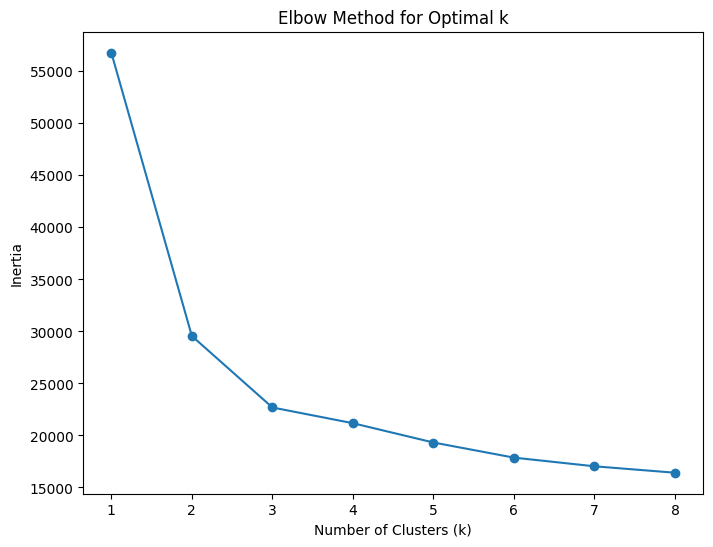

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Elbow Method to find optimal k
inertia = []
k_values = range(1, 9)
inertia = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

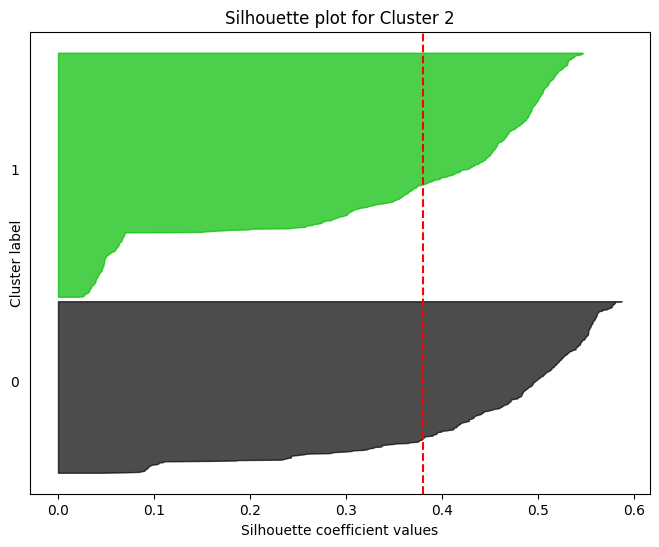

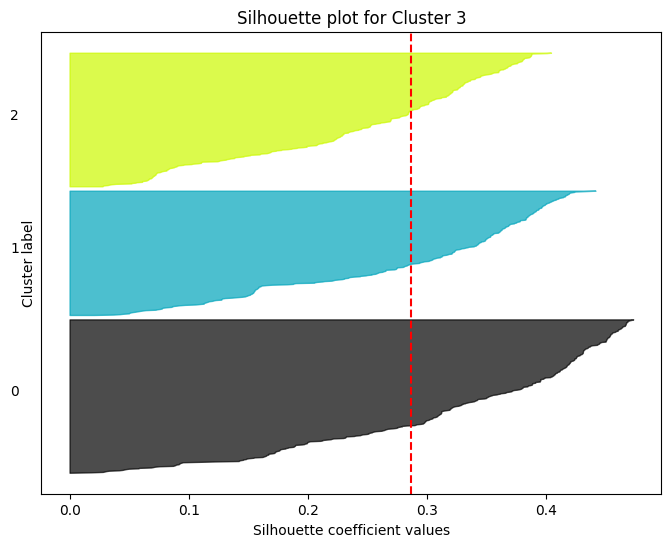

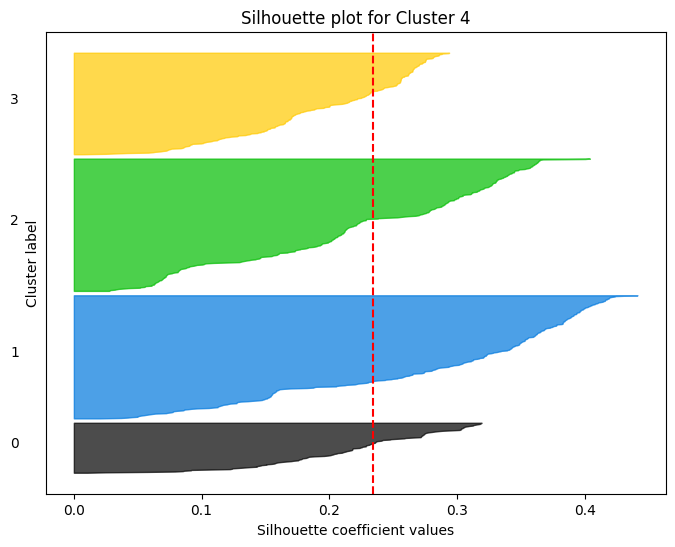

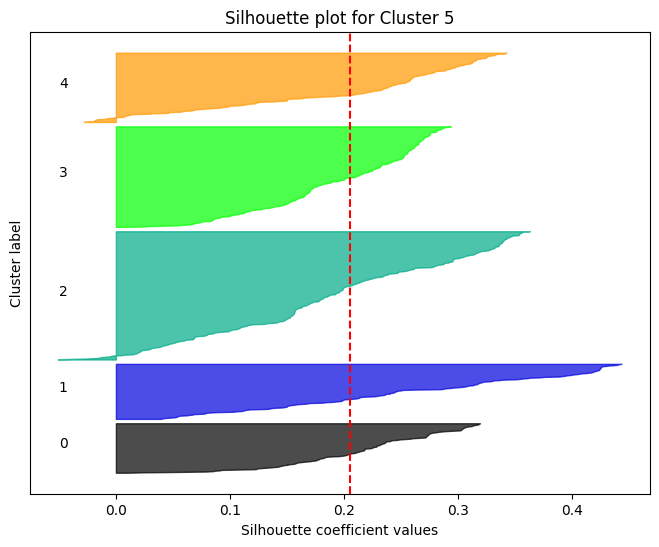

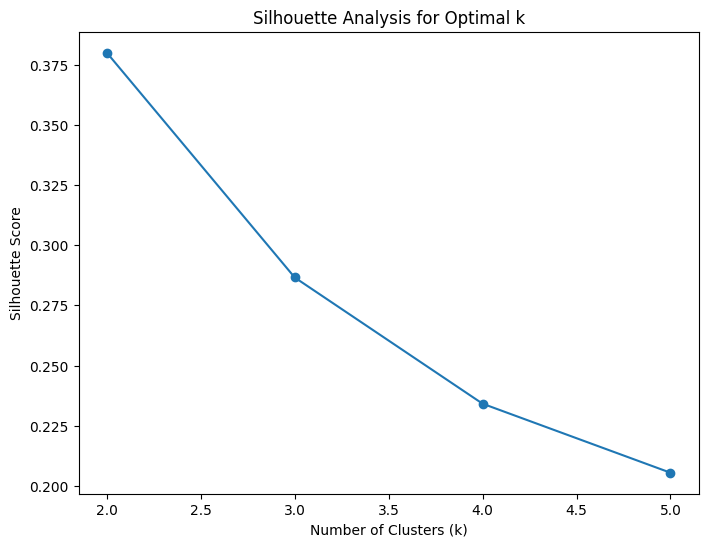

In [35]:
k_values = range(2, 6)

silhouette_scores = []
clusters = {}
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    clusters[k] = labels
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

    fig, ax = plt.subplots(figsize=(8, 6))

    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_title(f"Silhouette plot for Cluster {k}")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])

    plt.show()

# Plot Silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Analysis for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [36]:
target = pd.DataFrame(clusters[3])

K = 3 is best option, as it will not create the issue of High-dimensionality for each group while modeling for finding best model. Though K = 5 has great silhouette score but not great while creating the Stack Regression Modeling for predicting Saleprice as it can overfit the data due high dimensionality issues.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [38]:
x_train, x_val, y_train, y_val = train_test_split(x.values, target.values, test_size=0.2, random_state=36)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(x_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_val, y_pred))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00        68

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



In [39]:
df['clusters'] = target
print(df.clusters.unique())

[0 2 1]


In [40]:
grouped = df.groupby('clusters')
grouped_dfs = {}
for name, group in grouped:
    group = group.drop('clusters', axis =1)
    grouped_dfs[name] = group.copy()

In [41]:
print('Shape of each Group')
print(f'Group 1: {grouped_dfs[0].shape}')
print(f'Group 2: {grouped_dfs[1].shape}')
print(f'Group 3: {grouped_dfs[2].shape}')

Shape of each Group
Group 1: (381, 36)
Group 2: (309, 36)
Group 3: (332, 36)


In [42]:
from sklearn.ensemble import StackingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Group 1

In [81]:
dic_train_data = {}

def get_stacking(models):
    level0 = [(name, model) for name, model in models.items() if name != 'stacking_Grp1']
    level1 = LinearRegression()
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
    return model

def get_models():
    models = dict()

    # AdaBoostRegressor with grid search
    param_grid_adaboost = {'learning_rate': [0.02, 0.003, 0.0001], 'n_estimators':[50, 100, 200]}
    models['Adaboost_Grp1'] = GridSearchCV(AdaBoostRegressor(), param_grid_adaboost, scoring='neg_mean_squared_error', cv=5)

    # Ridge with grid search
    param_grid_ridge = {'alpha': [0.01, 0.001, 0.0001], 'max_iter': [50, 25, 100]}
    models['Ridge_Grp1'] = GridSearchCV(Ridge(), param_grid_ridge, scoring='neg_mean_squared_error', cv=5)

    # Lasso with grid search
    param_grid_lasso = {'alpha': [0.03, 0.003, 0.0003], 'max_iter':[100,25, 250]}
    models['Lasso_Grp1'] = GridSearchCV(Lasso(), param_grid_lasso, scoring='neg_mean_squared_error', cv=5)

    # GradientBoostingRegressor with grid search
    param_grid_gb = {'n_estimators': [25, 50, 200], 'learning_rate': [0.02, 0.002, 0.0002], 'max_depth': [6, 8, 12]}
    models['Gradient_Boosting_Grp1'] = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, scoring='neg_mean_squared_error', cv=5)

    models['stacking_Grp1'] = get_stacking(models)

    return models

X_ = grouped_dfs[0].drop('SalePrice', axis=1)
y_ = grouped_dfs[0]['SalePrice']

models_grp1 = get_models()
results_grp1, names_grp1 = list(), list()

best_model_name = None
best_model_mse = float('inf')

for name1, model1 in models_grp1.items():
    if name1 != 'stacking_Grp1':
        model1.fit(X_, y_)
        best_estimator = model1.best_estimator_ if isinstance(model1, GridSearchCV) else model1
        y_pred_1 = best_estimator.predict(X_)
        mse_grp1 = mean_squared_error(y_pred_1, y_)
        print('> %s %.3f' % (name1, mse_grp1))
        dic_train_data[name1] = mse_grp1
        results_grp1.append(mse_grp1)

        if mse_grp1 < best_model_mse:
            best_model_mse = mse_grp1
            best_model_name = name1

print(f"Best model for Group 1: {best_model_name} with MSE: {best_model_mse}")

stacking_model = models_grp1['stacking_Grp1']
base_estimators = [(name, model.best_estimator_ if isinstance(model, GridSearchCV) else model) for name, model in models_grp1.items() if name != 'stacking_Grp1']
stacking_model.named_estimators_ = dict(base_estimators)
stacking_model.fit(X_, y_)

y_pred_stacking = stacking_model.predict(X_)
mse_stacking = mean_squared_error(y_pred_stacking, y_)
print(f'Stacking Model MSE: {mse_stacking}')


> Adaboost_Grp1 653437599.277
> Ridge_Grp1 763757415.736
> Lasso_Grp1 763752146.509
> Gradient_Boosting_Grp1 14739583.704
Best model for Group 1: Gradient_Boosting_Grp1 with MSE: 14739583.704458317
Stacking Model MSE: 68261307.73597625


# Group 2

In [44]:
def get_stacking_1(models):
    level0 = [(name, model) for name, model in models.items() if name != 'Stacking_Grp2']
    level1 = LinearRegression()
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
    return model

def get_models_1():
    models = dict()
    # Rfr with grid search
    param_grid_rf = {'max_depth': [10, 7, 5], 'n_estimators': [50, 100]}
    models['RFR_Grp2'] = GridSearchCV(RandomForestRegressor(), param_grid_rf, scoring='neg_mean_squared_error', cv=5)

    # Ridge with grid search
    param_grid_ridge = {'alpha': [0.01, 0.001, 0.0001], 'max_iter': [50, 100, 250]}
    models['Ridge_Grp2'] = GridSearchCV(Ridge(), param_grid_ridge, scoring='neg_mean_squared_error', cv=5)

    # Lasso with grid search
    param_grid_lasso = {'alpha': [0.03, 0.003, 0.0003], 'max_iter':[50, 25, 250]}
    models['Lasso_Grp2'] = GridSearchCV(Lasso(), param_grid_lasso, scoring='neg_mean_squared_error', cv=5)

    # Adaboost Regressor
    param_grid_adaboost = {'learning_rate': [0.02, 0.003, 0.0001], 'n_estimators':[50, 100, 200]}
    models['Adaboost_Grp2'] = GridSearchCV(AdaBoostRegressor(), param_grid_adaboost, scoring='neg_mean_squared_error', cv=5)

    models['Stacking_Grp2'] = get_stacking_1(models)
    return models

# Assuming grouped_dfs is a list of DataFrames
X_2 = grouped_dfs[1].drop('SalePrice', axis=1)
y_2 = grouped_dfs[1]['SalePrice']
# x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_2, test_size=0.2)
# print(x_train_2.shape, y_train_2.shape, x_val_2.shape, y_val_2.shape)

models_grp2 = get_models_1()
results_grp2, names_grp2 = list(), list()

best_mse_grp2 = float('inf')
best_model_name2 = None

for name_grp2, model_grp2 in models_grp2.items():
    if name_grp2 != 'Stacking_Grp2':
        model_grp2.fit(X_2, y_2)
        best_estimator = model_grp2.best_estimator_ if isinstance(model_grp2, GridSearchCV) else model_grp2
        y_pred_2 = best_estimator.predict(X_2)
        mse_grp2 = mean_squared_error(y_pred_2, y_2)
        print('>%s %.3f' % (name_grp2, mse_grp2))
        dic_train_data[name_grp2] = mse_grp2
        results_grp2.append(mse_grp2)

        if mse_grp2 < best_mse_grp2:
            best_mse_grp2 = mse_grp2
            best_model_name2 = name_grp2

print(f"Best model for Group 2: {best_model_name2} with MSE: {best_mse_grp2}")

stacking_model2 = models_grp2['Stacking_Grp2']
base_estimators2 = [(name, model.best_estimator_ if isinstance(model, GridSearchCV) else model) for name, model in models_grp2.items() if name != 'Stacking_Grp2']
stacking_model2.named_estimators_ = dict(base_estimators2)
stacking_model2.fit(X_2, y_2)

y_pred_stacking_2 = stacking_model2.predict(X_2)
mse_stacking_2 = mean_squared_error(y_pred_stacking_2, y_2)
print(f'Stacking Model MSE: {mse_stacking_2}')

>RFR_Grp2 157618400.339
>Ridge_Grp2 638648366.645
>Lasso_Grp2 638648361.832
>Adaboost_Grp2 598971734.750
Best model for Group 2: RFR_Grp2 with MSE: 157618400.33894652
Stacking Model MSE: 342066829.6855667


# Group 3

In [45]:
def get_stacking_2(models):
    level0 = [(name, model) for name, model in models.items() if name != 'Stacking_Grp3']
    level1 = LinearRegression()
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
    return model

def get_models_2():
    models = dict()

    # Random Forest Regressor
    param_grid_rf = {'max_depth': [10, 7, 5], 'n_estimators': [50, 100, 150]}
    models['RFR_Grp3'] = GridSearchCV(RandomForestRegressor(), param_grid_rf, scoring='neg_mean_squared_error', cv=5)

    # Ridge with grid search
    param_grid_ridge = {'alpha': [0.03, 0.003, 0.0003], 'max_iter': [50, 100]}
    models['Ridge_Grp3'] = GridSearchCV(Ridge(), param_grid_ridge, scoring='neg_mean_squared_error', cv=5)

    # Lasso with grid search
    param_grid_lasso = {'alpha': [0.02, 0.002, 0.0002], 'max_iter': [100, 250]}
    models['Lasso_Grp3'] = GridSearchCV(Lasso(), param_grid_lasso, scoring='neg_mean_squared_error', cv=5)

    # Xgb regressor with grid search
    param_grid_xgb = {'n_estimators': [50, 100, 25], 'learning_rate': [0.02, 0.003, 0.0001], 'max_depth': [5, 7]}
    models['XGBRegressor_Grp3'] = GridSearchCV(XGBRegressor(), param_grid_xgb, scoring='neg_mean_squared_error', cv=5)

    models['Stacking_Grp3'] = get_stacking_2(models)
    return models

X_3 = grouped_dfs[2].drop('SalePrice', axis=1)
y_3 = grouped_dfs[2]['SalePrice']
# x_train_3, x_val_3, y_train_3, y_val_3 = train_test_split(X_3, y_3, test_size=0.3)
# print(x_train_3.shape, y_train_3.shape, x_val_3.shape, y_val_3.shape)

results_grp3, names_grp3 = list(), list()
models_grp3 = get_models_2()
best_mse_grp3 = float('inf')
best_model_name3 = None

for name_grp3, model_grp3 in models_grp3.items():
    if name_grp3 != 'Stacking_Grp3':
        model_grp3.fit(X_3, y_3)
        best_estimator = model_grp3.best_estimator_ if isinstance(model_grp3, GridSearchCV) else model_grp3
        y_pred_3 = best_estimator.predict(X_3)
        mse_grp3 = mean_squared_error(y_pred_3, y_3)
        print(f'>{name_grp3} {mse_grp3:.3f}')
        dic_train_data[name_grp3] = mse_grp3
        results_grp3.append(mse_grp3)

        if mse_grp3 < best_mse_grp3:
            best_mse_grp3 = mse_grp3
            best_model_name3 = name_grp3

print(f"Best model for Group 3: {best_model_name3} with MSE: {best_mse_grp3}")

stacking_model3 = models_grp3['Stacking_Grp3']
base_estimators3 = [(name, model.best_estimator_ if isinstance(model, GridSearchCV) else model) for name, model in models_grp3.items() if name != 'Stacking_Grp3']
stacking_model3.named_estimators_ = dict(base_estimators3)
stacking_model3.fit(X_3, y_3)

y_pred_stacking_3 = stacking_model3.predict(X_3)
mse_stacking_3 = mean_squared_error(y_pred_stacking_3, y_3)
print(f'Stacking Model MSE: {mse_stacking_3}')

>RFR_Grp3 185223262.460
>Ridge_Grp3 1046444085.528
>Lasso_Grp3 1045436895.458
>XGBRegressor_Grp3 552886861.905
Best model for Group 3: RFR_Grp3 with MSE: 185223262.46035942
Stacking Model MSE: 380462181.83079493


In [46]:
train_MSE = pd.DataFrame(dic_train_data.items(), columns = ['Model_Name', 'MSE'])

In [47]:
train_MSE.sort_values('MSE')

,Model_Name,MSE
3,Gradient_Boosting_Grp1,1.548129e+07
4,RFR_Grp2,1.576184e+08
8,RFR_Grp3,1.852233e+08
11,XGBRegressor_Grp3,5.528869e+08
7,Adaboost_Grp2,5.989717e+08
6,Lasso_Grp2,6.386484e+08
5,Ridge_Grp2,6.386484e+08
0,Adaboost_Grp1,6.786964e+08
2,Lasso_Grp1,7.637521e+08
1,Ridge_Grp1,7.637574e+08


# Test Data Model

In [77]:
test_data = pd.read_csv('/content/sample_data/test.csv')

In [78]:
test_data.shape

(438, 82)

In [79]:
from sklearn.preprocessing import StandardScaler

In [82]:
def test_data_des(data):
    #mode imputation
    data = mode_imputation(data, categorical)
    data = data[list_of_features]

    # skewed_columns = df[skewnames]
    # for column in skewed_columns.columns:
    #   skewed_columns[column], _ = boxcox(skewed_columns[column] + 1)
    # data[skewnames] = skewed_columns

    # Non-categorical data handling
    noncat = data.select_dtypes(exclude=['object']).columns
    test_col_data = pd.DataFrame(knn_imputer.transform(data[selected_columns]), columns=selected_columns)
    data[selected_columns] = test_col_data

    data[cols_norm] = scaler_norm.transform(data[cols_norm])

    # Categorical data handling
    cat = data.select_dtypes(include=['object']).columns
    data[cat] = encoder_ord.transform(data[cat])

    # Split the data
    x = data.drop('SalePrice', axis=1)
    y = data['SalePrice']

    dic_grp1 = {}

    # Modeling with group1
    for name1, model1 in models_grp1.items():
        y_pred_test_1 = model1.predict(x)
        mse_test_grp1 = mean_squared_error(y_pred_test_1, y)
        dic_grp1[name1] = mse_test_grp1

    # Modeling with group2
    for name_grp2, model_grp2 in models_grp2.items():
        if name_grp2 != 'Stacking_Grp2':
            if isinstance(model_grp2,(Ridge,Lasso)):
                scaler = StandardScaler() #to overcome overfitting
                x_scaled = scaler.fit_transform(x)
                model_grp2.fit(x_scaled, y)
            else:
                model_grp2.fit(x, y)
        y_pred_test_2 = model_grp2.predict(x)
        mse_test_grp2 = mean_squared_error(y_pred_test_2, y)
        dic_grp1[name_grp2] = mse_test_grp2

    # Modeling with group3
    for name_grp3, model_grp3 in models_grp3.items():
        if name_grp3 != 'Stacking_Grp3':
            if isinstance(model_grp3,(Ridge,Lasso)):
                scaler = StandardScaler() #to overcome overfitting
                x_scaled = scaler.fit_transform(x)
                model_grp3.fit(x_scaled, y)
            else:
                model_grp3.fit(x, y)

        y_pred_test_3 = model_grp3.predict(x)
        mse_test_grp3 = mean_squared_error(y_pred_test_3, y)
        dic_grp1[name_grp3] = mse_test_grp3

    return dic_grp1

# Assuming 'test_data' is your test dataset
test_result = test_data_des(test_data)
test_pred_data = pd.DataFrame(test_result.items(), columns=['Model_Name','MSE'])
test_pred_data.sort_values('MSE')

,Model_Name,MSE
5,RFR_Grp2,2.590192e+08
10,RFR_Grp3,2.659910e+08
13,XGBRegressor_Grp3,4.367451e+08
12,Lasso_Grp3,9.741232e+08
6,Ridge_Grp2,9.741324e+08
7,Lasso_Grp2,9.741554e+08
11,Ridge_Grp3,9.742023e+08
8,Adaboost_Grp2,1.108508e+09
9,Stacking_Grp2,1.118336e+09
4,stacking_Grp1,1.362449e+09


We are not sure wether above method for overfitting is feasible or not. Though, It helped us to over overfitting and got us similar output as of Train dataset.

P.S: The values can change in fractions but overall the observations will remain same.

At each point, we tried to use and apply different ways of Feature selection [like one_hot encoding and then feature selection, different statistical test, only modeling]
For Clustering tried [K Means, Hierarical clustering, Standard scaler values,..]
For Modeling tried [XGBRegressor, LGBRegressor, CatBoosting Regressor, SVR, ....]
To overcome overfitting tried [Sparsity evaluation, hypertuning, standard scaling at test data,...]